In [1]:
#CERES-EBAF Data - Code to read in data, plot timeseries of top of atmosphere radiation and energy balance
#Jennifer Kay (Jennifer.E.Kay@colorado.edu University of Colorado)
#Last updated: June 18, 2021

%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import scipy.stats as stats ## https://docs.scipy.org/doc/scipy/reference/stats.html

In [2]:
## open the CERES-EBAF dataset using xarray
ds = xr.open_dataset("CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc")
#ds   ## when you type "ds" - it prints information about the file to the screen.  

lat=ds["lat"]
lon=ds["lon"]
ds

<xarray.Dataset>
Dimensions:            (lat: 180, lon: 360, time: 252)
Coordinates:
  * lon                (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat                (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time               (time) datetime64[ns] 2000-03-15 ... 2021-02-15
Data variables:
    toa_sw_all_mon     (time, lat, lon) float32 ...
    toa_lw_all_mon     (time, lat, lon) float32 ...
    toa_net_all_mon    (time, lat, lon) float32 ...
    toa_sw_clr_c_mon   (time, lat, lon) float32 ...
    toa_lw_clr_c_mon   (time, lat, lon) float32 ...
    toa_net_clr_c_mon  (time, lat, lon) float32 ...
    solar_mon          (time, lat, lon) float32 ...
Attributes:
    title:        CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Monthly...
    institution:  NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.1; Release Date May 28, 2019
    DOI:          10.5067/TERRA-AQUA/CERES/EBAF-TOA_L3B004.1

In [3]:
### Calculate top of atmosphere energy imbalance (NetSW+NetLW)

### Outgoing longwave radiation (OLR)
OLR=ds.toa_lw_all_mon
### Calculate absorbed shortwave radiation (ASR)
OSR=ds.toa_sw_all_mon ### outgoing solar radiation, measured by CERES
SOLIN=ds.solar_mon    ### incoming solar radiation, from the sun
ASR=SOLIN-OSR  ### sign convention, positive down.  incoming solar radiation minus outgoing solar radiation
netLW=-OLR                  ### Note that we are taking -OLR so that the sign convention is all positive down
netSW=ASR
netTOAimbalance=netSW+netLW ### sign convention positive down

In [4]:
### Take the global mean
cos_lat=np.cos(lat*np.pi/180)
zmean=netTOAimbalance.mean('lon')
gm_netTOAimbalance=(zmean*cos_lat).sum('lat')/np.nansum(cos_lat)
print(gm_netTOAimbalance.shape)

(252,)


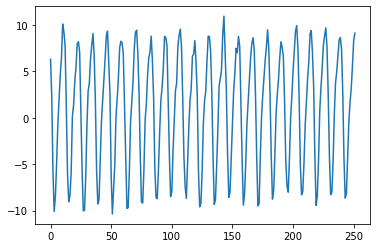

In [5]:
#### simple sanity plot
plt.plot(gm_netTOAimbalance);

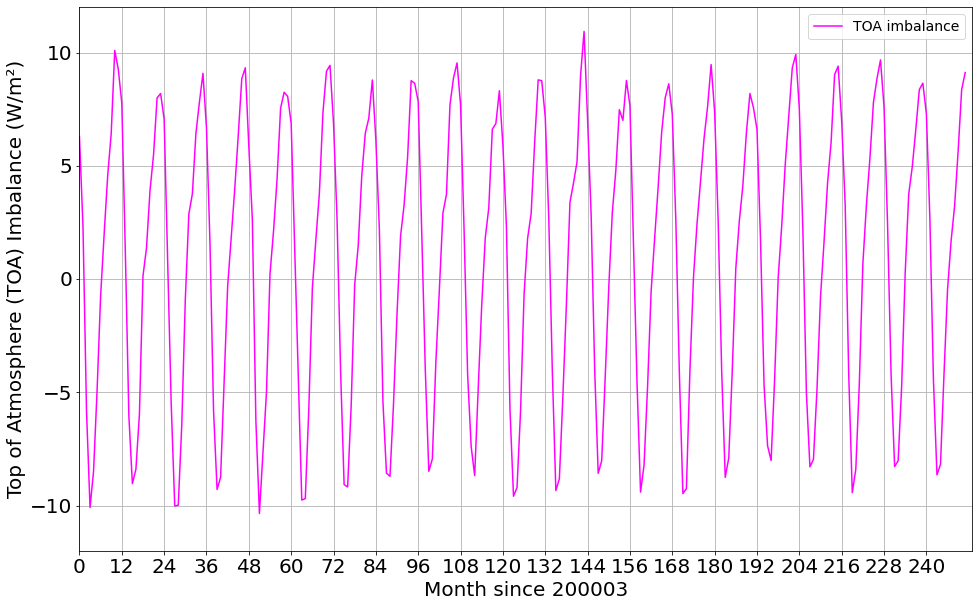

In [6]:
#### science plot
fig = plt.figure(figsize=(16,10));

## plot CESM2 LE ensemble members
plt.plot(gm_netTOAimbalance,color="magenta", label='TOA imbalance');  

plt.ylabel('Top of Atmosphere (TOA) Imbalance (W/m\u00b2)', fontsize=20);
plt.xlabel('Month since 200003', fontsize=20);

plt.grid()
plt.xticks(np.arange(0,252,12),fontsize=20);
plt.yticks(fontsize=20);
plt.xlim((0,253));
plt.ylim((-12,12));
plt.legend(loc='upper right', fontsize=14);

#plt.savefig('CERES-EBAF_timeseries_TOAimbalance.png', dpi=300, bbox_inches='tight', format='png');

In [7]:
## calculate the linear trend over the entire monthly mean global timeseries
## stats.linregress is a "built in function" to compute the linear trend
## documentation of the function
##https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html#scipy.stats.linregress
y=gm_netTOAimbalance
print(y.shape)
### this nmonths calculations leads to a variable type that is not easily used, ###CHECK
#nmonths=gm_netTOAimbalance.shape
#print(nmonths)
#x=np.arange(1,252+1,1)
x=np.arange(0,252,1)      #this makes it so x-axis goes from the starting point all the way to the 252nd month since March of 2003
print(x.shape)
print(x)

(252,)
(252,)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 

In [8]:
slope, intercept, r_value, p_value, std_err =stats.linregress(x,y)
slope_per_year=slope/21  ## divide by 21 years to get the slope in units of Wm-2/year
print("Slope (Wm-2/year):"+str(np.round(slope_per_year,3)))

Slope (Wm-2/year):0.0


In [9]:
#### Look at the Arctic - in August (selected because there's incoming shortwave and sea ice loss)

In [10]:
### Take the Arctic mean (taking the average from 70-90 North)
cos_lat=np.cos(lat*np.pi/180)
zmean=ASR.mean('lon')
cos_lat_arctic=cos_lat.sel(lat=slice(70,90))
#print(cos_lat_arctic.shape)
zmean_arctic=zmean.sel(lat=slice(70,90))
#print(zmean_arctic.shape)
am_ASR=(zmean_arctic*cos_lat_arctic).sum('lat')/np.nansum(cos_lat_arctic)
print(am_ASR.shape)

## 0 = March, 0+4 = July, 0+5 = August, 0+6 = September
am_ASR_june=am_ASR[0+3::12]
am_ASR_july=am_ASR[0+4::12]
am_ASR_august=am_ASR[0+5::12]
am_ASR_september=am_ASR[0+6::12]

(252,)


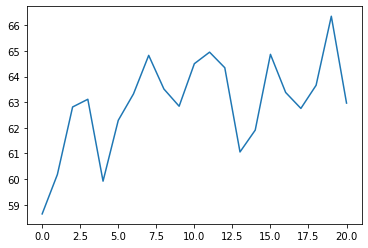

In [11]:
## make a sanity plot
plt.plot(am_ASR_september);  

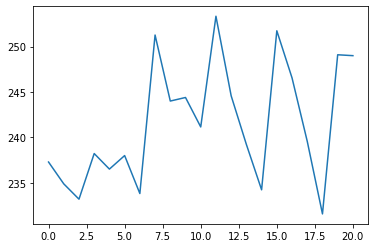

In [12]:
plt.plot(am_ASR_july)

In [30]:
## calculate the linear trend over the entire monthly mean global timeseries
## stats.linregress is a "built in function" to compute the linear trend
## documentation of the function
##https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html#scipy.stats.linregress
#smallest slope
y=am_ASR_september
print(y.shape)
x=np.arange(0,252/12,1)
print(x.shape)
#print(x)
slope_sept, intercept_sept, r_value_sept, p_value_sept, std_err_sept =stats.linregress(x,y)
slope_per_year=slope  ## slope already has units of per-year because it is only for one month (e.g., All Septembers)
print("Arctic (70-90 N) ASR Slope in September (Wm-2/year):"+str(np.round(slope_per_year,3)))

(21,)
(21,)
Arctic (70-90 N) ASR Slope in September (Wm-2/year):0.002


In [14]:
#### try in different months of the year, Is the slope larger or smaller? (Renato to do)
#largest slope
y=am_ASR_july
print(y.shape)
x=np.arange(0,252/12,1)
print(x.shape)
#print(x)
slope, intercept, r_value, p_value, std_err =stats.linregress(x,y)
slope_per_year=slope  ## slope already has units of per-year because it is only for one month (e.g., All Septembers)
print("Arctic (70-90 N) ASR Slope in July (Wm-2/year):"+str(np.round(slope_per_year,3)))

(21,)
(21,)
Arctic (70-90 N) ASR Slope in July (Wm-2/year):0.449


In [15]:
#2nd largest slope
y=am_ASR_august
print(y.shape)
x=np.arange(0,252/12,1)
print(x.shape)
#print(x)
slope, intercept, r_value, p_value, std_err =stats.linregress(x,y)
slope_per_year=slope  ## slope already has units of per-year because it is only for one month (e.g., All Septembers)
print("Arctic (70-90 N) ASR Slope in August (Wm-2/year):"+str(np.round(slope_per_year,3)))

(21,)
(21,)
Arctic (70-90 N) ASR Slope in August (Wm-2/year):0.267


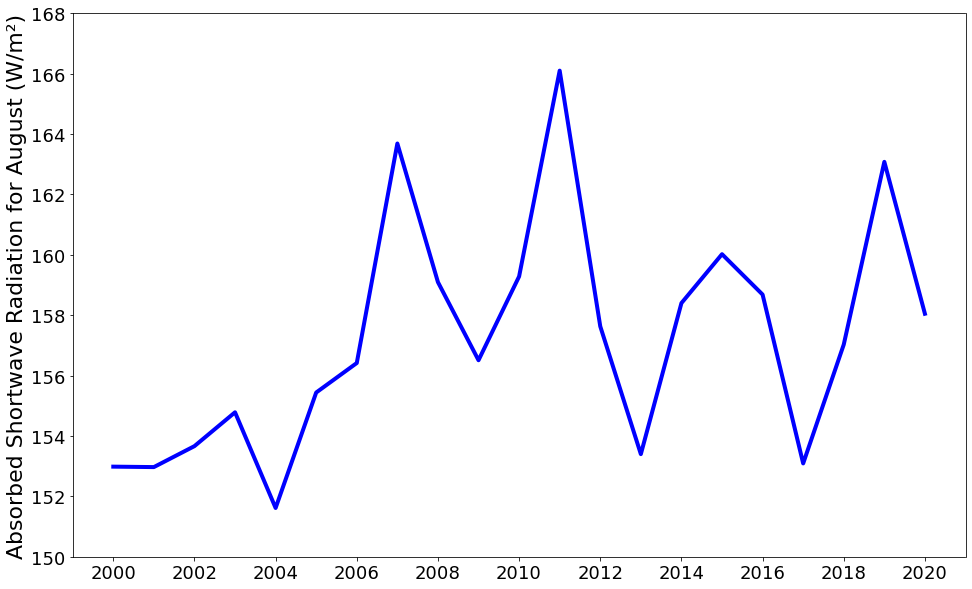

In [28]:
#### science plot
fig = plt.figure(figsize=(16,10));

## plot CESM2 LE ensemble members
plt.plot(am_ASR_august,color="blue", linewidth=4, label='Absorbed August');  

plt.ylabel("Absorbed Shortwave Radiation for August (W/m\u00b2)", fontsize=22);
#plt.xlabel('Year', fontsize=20);

yticks=np.arange(150,170,2);
xticks=np.arange(0,21,2);
xlab=np.arange(2000,2021,2);
plt.xticks(xticks,xlab,size='18');
plt.yticks(yticks,fontsize=18);
#plt.xlim((0,253));
#plt.ylim((-12,12));
#plt.legend(loc='upper right', fontsize=14);


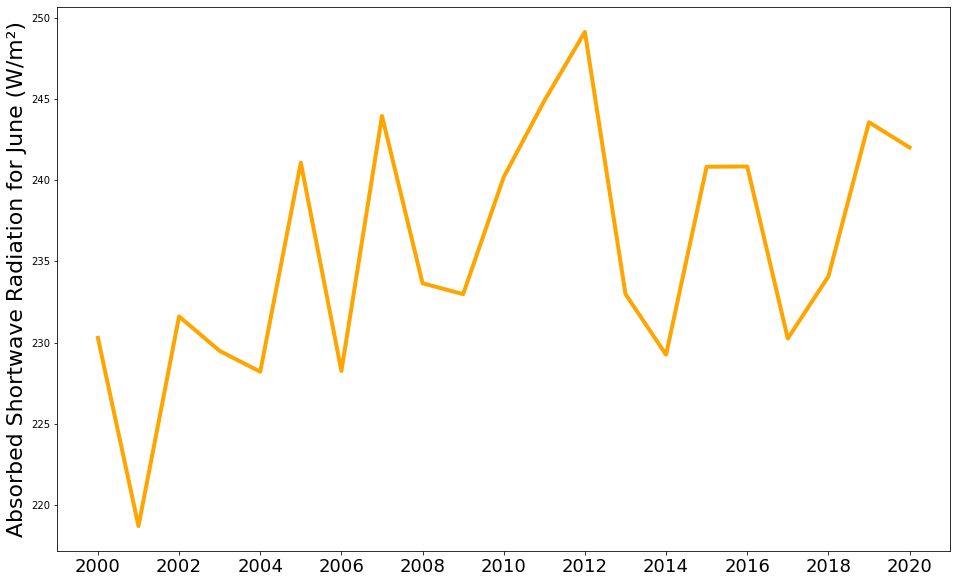

In [17]:
#### science plot
fig = plt.figure(figsize=(16,10));

## plot CESM2 LE ensemble members
plt.plot(am_ASR_june,color="orange", linewidth=4, label='Absored June');  

plt.ylabel("Absorbed Shortwave Radiation for June (W/m\u00b2)", fontsize=22);
#plt.xlabel('Year', fontsize=20);

#yticks=np.arange(230,260,2);
xticks=np.arange(0,21,2);
xlab=np.arange(2000,2021,2);
plt.xticks(xticks,xlab,size='18');
#plt.yticks(yticks,fontsize=18);
#plt.xlim((0,253));
#plt.ylim((-12,12));
#plt.legend(loc='upper right', fontsize=14);


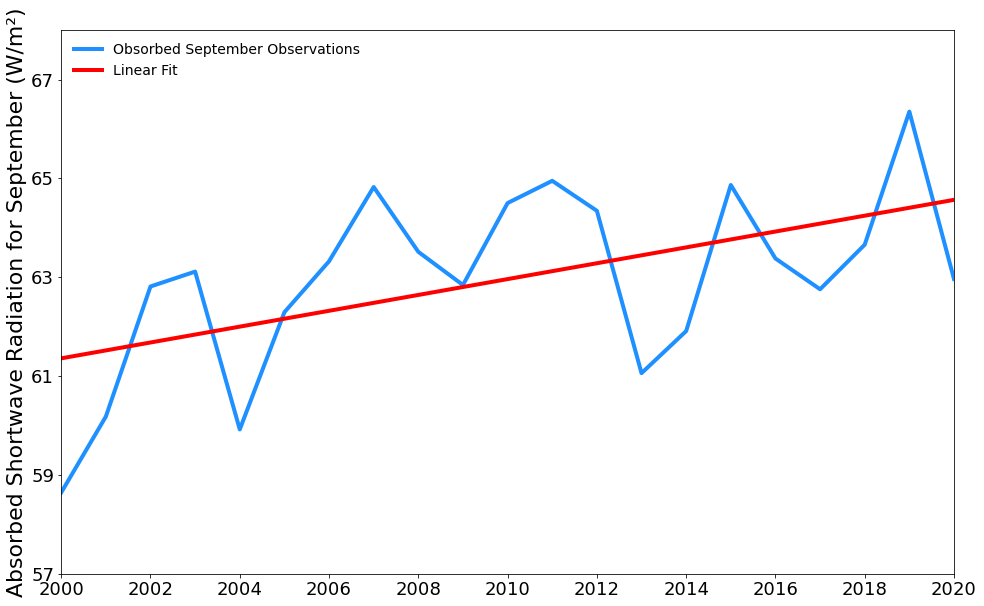

In [36]:
##### science plot
month='Sept.'
data=am_ASR_september
slope=slope_sept
intercept=intercept_sept

fig = plt.figure(figsize=(16,10));
## plot CESM2 LE ensemble members
plt.plot(x,data,color="dodgerblue", linewidth=4, label='Obsorbed September Observations');  
plt.plot(x,x*slope+intercept,color="red", linewidth=4, label='Linear Fit');  
plt.ylabel("Absorbed Shortwave Radiation for September (W/m\u00b2)", fontsize=22);

plt.ylim([58,68])
plt.xlim([0,20]);
yticks=np.arange(57,68,2);
xticks=np.arange(0,21,2);
xlab=np.arange(2000,2021,2);
plt.xticks(xticks,xlab,size='18');
plt.yticks(yticks,fontsize=18);
plt.legend(loc='upper left',fontsize=14,edgecolor='None');


In [19]:
#Calculate linear trends

In [20]:
###
### This is taking the incoming shortwave mean
SWmean=netSW.mean('lon')
gm_SWmean=(SWmean*cos_lat).sum('lat')/np.nansum(cos_lat)
print(gm_SWmean.shape)
#plt.plot(gm_SWmean)

(252,)


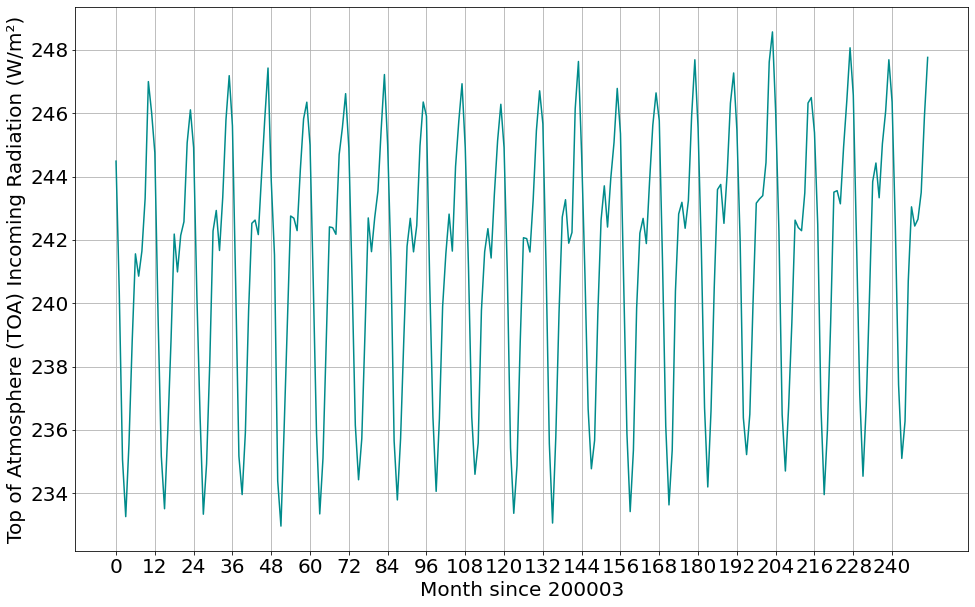

In [21]:
###
#### science plot
fig = plt.figure(figsize=(16,10));

## plot CESM2 LE ensemble members
plt.plot(gm_SWmean,color="darkcyan" );  

plt.ylabel('Top of Atmosphere (TOA) Incoming Radiation (W/m\u00b2)', fontsize=20);
plt.xlabel('Month since 200003', fontsize=20);

plt.grid()
plt.xticks(np.arange(0,252,12),fontsize=20);
plt.yticks(fontsize=20);
#plt.xlim((0,253));
#plt.ylim((-12,12));
#plt.legend(loc='upper right', fontsize=14);


In [22]:
#Getting linear trends for global incoming shortwave radiation
y1=gm_SWmean
print(y1.shape)
x1=np.arange(0,252,1)
print(x1.shape)
print(x1)

(252,)
(252,)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 

In [23]:
slope, intercept, r_value, p_value, std_err =stats.linregress(x1,y1)
slope_per_yearSW=slope/21  ## divide by 21 years to get the slope in units of Wm-2/year
print("Slope (Wm-2/year):"+str(np.round(slope_per_yearSW,4)))

Slope (Wm-2/year):0.0003


In [24]:
### Doing the same for longwave

LWmean=OLR.mean('lon')
gm_LWmean=(LWmean*cos_lat).sum('lat')/np.nansum(cos_lat)
print(gm_LWmean.shape)
#plt.plot(gm_LWmean)

(252,)


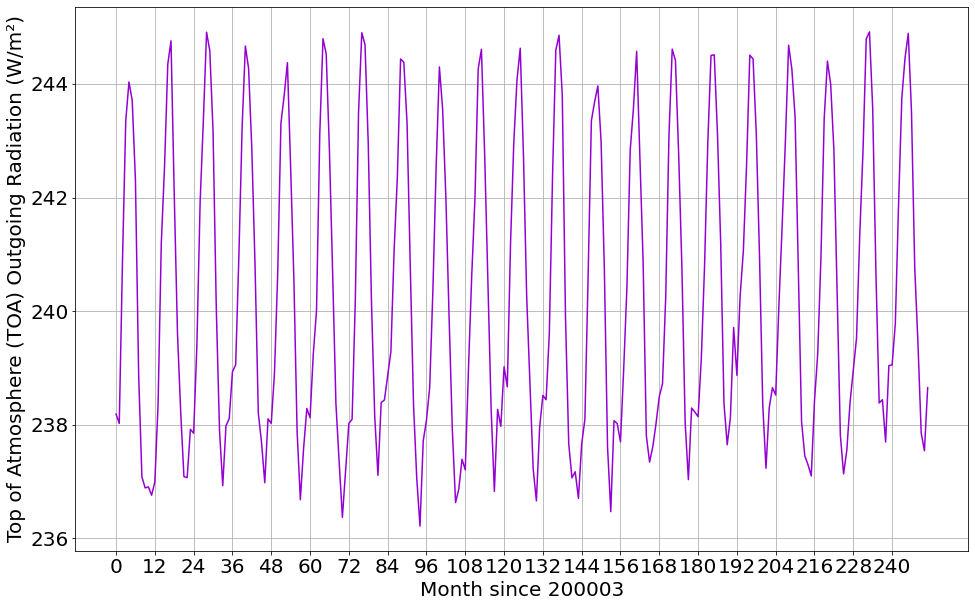

In [25]:
###
#### science plot
fig = plt.figure(figsize=(16,10));

## plot CESM2 LE ensemble members
plt.plot(gm_LWmean,color="darkviolet");  

plt.ylabel('Top of Atmosphere (TOA) Outgoing Radiation (W/m\u00b2)', fontsize=20);
plt.xlabel('Month since 200003', fontsize=20);

plt.grid()
plt.xticks(np.arange(0,252,12),fontsize=20);
plt.yticks(fontsize=20);
#plt.xlim((0,253));
#plt.ylim((-12,12));
#plt.legend(loc='upper right', fontsize=14);


In [26]:
#Getting linear trends for global outgoing longwave radiation
y2=gm_LWmean
print(y2.shape)
x2=np.arange(0,252,1)
print(x2.shape)
print(x2)

(252,)
(252,)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 

In [27]:
slope, intercept, r_value, p_value, std_err =stats.linregress(x2,y2)
slope_per_yearLW=slope/21  ## divide by 21 years to get the slope in units of Wm-2/year
print("Slope (Wm-2/year):"+str(np.round(slope_per_yearLW,4)))

Slope (Wm-2/year):0.0001
